# Evaluation of Graph Neural Network Tracker 

In [1]:
# System imports
import os
import sys
import pprint
from collections import deque

# External imports
import matplotlib.pyplot as plt
import numpy as np

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Local imports
from nb_utils import (compute_metrics, plot_metrics, draw_sample_xy, draw_sample, load_summaries)

n_phi_sections = 1
feature_scale_r = 15.0
feature_scale_phi =  1.0
feature_scale_z = 50.0

feature_scale = np.array([feature_scale_r, np.pi / n_phi_sections / feature_scale_phi, feature_scale_z])


In /home/benjamin/b2/externals/v01-10-00/Linux_x86_64/common/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/belle2.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/benjamin/b2/externals/v01-10-00/Linux_x86_64/common/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/belle2.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/benjamin/b2/externals/v01-10-00/Linux_x86_64/common/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/belle2.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/benjamin/b2/externals/v01-10-00/Linux_x86_64/common/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/belle2_serif.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated i

In [2]:
%pwd

'/home/benjamin/xtracker/notebooks'

In [3]:
%matplotlib notebook

## Load the trained model

In [4]:
# Need to adjust this to output of graph generation
data_dir = './../examples/data/hitgraphs_belle2_vtxonly'  

# Need to adjust this to checkpoints from training on graphs
checkpoint_dir = './../examples/temp_vtx/'

In [5]:
from xtracker.gnn_tracking.ImTracker import ImTracker 


from xtracker.gnn_tracking.TrackingSolver import TrackingSolver
from xtracker.gnn_tracking.TrackingGame import TrackingGame as Game
from xtracker.gnn_tracking.pytorch.NNet import NNetWrapper as NNet
import numpy as np
from xtracker.utils import dotdict
from torch.utils.data import DataLoader
from itertools import cycle
from xtracker.datasets import get_data_loaders

data_args = dotdict({
    'batch_size': 1,
    'name': 'hitgraphs_sparse',
    'input_dir': data_dir,
    'n_train': 50, #128, #8000 
    'n_valid': 50, #128, #1000
})


tracker_args = dotdict({
    'nIter': 20,
    'verbose': False, 
    'mid_steps': 4,
    'noise_sigma': 0.0,  
    'update_e': False, 
})

# Data loaders for training and validation 
train_data_loader, valid_data_loader = get_data_loaders(**data_args)
assert valid_data_loader is not None
assert train_data_loader is not None

valid_data_loader = cycle(valid_data_loader)
train_data_loader = cycle(train_data_loader)


game = Game(train_data_loader, valid_data_loader)

In [6]:
summaries = load_summaries(checkpoint_dir)

print('\nTraining summaries:')
summaries


Training summaries:


,play_time,train_time,pit_time,iter,train_sampled_examples,pit_nnet_score,pit_pnet_score
0,10.125361,887.588218,288.636252,1,18527,0.260862,0.000000
1,8.970977,1679.106447,152.858052,2,17388,0.260862,0.261818
2,9.774806,1807.717096,162.358485,3,18357,0.295699,0.261818
3,8.421845,1765.780863,159.712661,4,16882,0.261144,0.303605
4,9.367879,1736.827941,158.952978,5,18243,0.260862,0.262114
5,8.869231,1831.243144,161.071232,6,17727,0.260862,0.261818
6,8.917967,1805.470119,176.922457,7,17574,0.891937,0.261818
7,9.048048,1810.574557,170.016430,8,17761,0.332827,0.889903
8,9.102717,1833.993470,172.726983,9,18008,0.260995,0.332184
9,9.604141,1904.974573,170.970784,10,18397,0.260928,0.262099


In [7]:
# Find the best epoch
best_idx = summaries.pit_nnet_score.idxmax()
summaries.loc[[best_idx]]



,play_time,train_time,pit_time,iter,train_sampled_examples,pit_nnet_score,pit_pnet_score
6,8.917967,1805.470119,176.922457,7,17574,0.891937,0.261818


In [8]:
summaries.loc[[best_idx]].pit_nnet_score.item()

0.8919366380355568

In [9]:
# Load neural net
n1 = NNet()
n1.load_checkpoint(checkpoint_dir,'best.pth.tar')

# Built a tracker
tracker = ImTracker(game, n1, tracker_args)

In [10]:
from xtracker.gnn_tracking.TrackingLogic import Board

def getInitBoard(graph):
    b = Board()
    b.edge_index = graph.edge_index.numpy().copy()
    b.x = graph.x.numpy().copy()
    b.y = graph.y.numpy().copy()
    b.y_pred = np.ones_like(b.y)
    return b

def reset_edges(board):
    """Reset active egdes to board. 
    """
    
    # Reset all edges from initial board 
    board.y_pred = np.ones_like(board.y)    
    
    # Reopen the game 
    board.next_player = 1        



# Evaluate tracker on individual events 

score= 0.9307692307692308


<IPython.core.display.Javascript object>


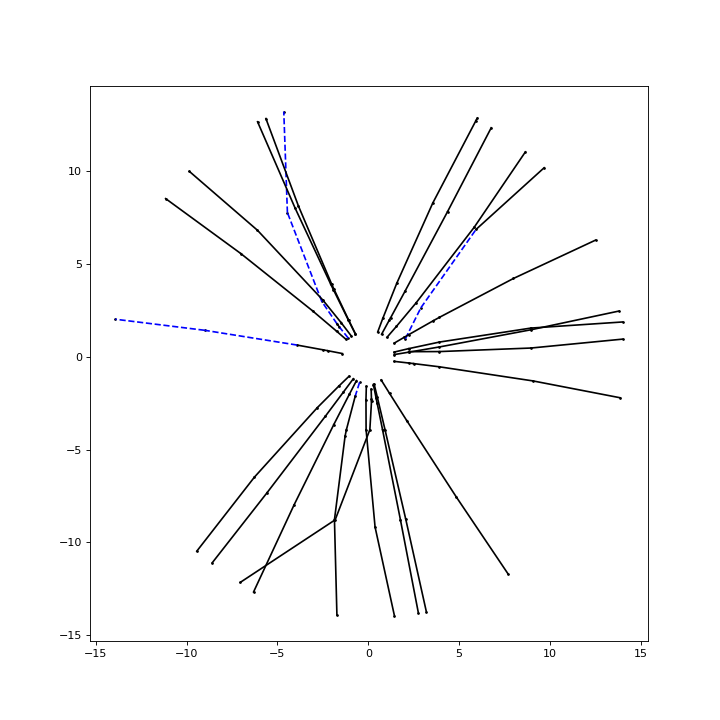

<IPython.core.display.Javascript object>


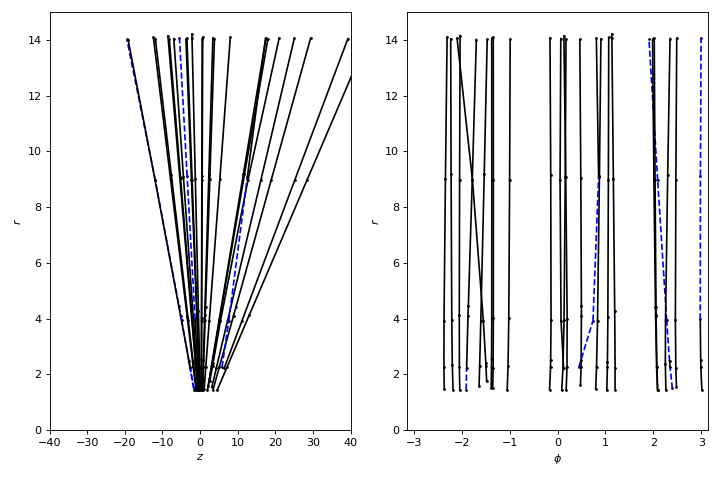

CPU times: user 2.07 s, sys: 90.8 ms, total: 2.16 s
Wall time: 1.01 s


In [11]:
%%time

graph = next(valid_data_loader)  
board = getInitBoard(graph)

pred, score = tracker.process(board)   
print('score=', score)


draw_sample_xy(board.x * feature_scale, board.edge_index, pred, board.y, cut=0.5, mconly=False, fullonly=False,
              figsize=(9, 9)
)
draw_sample(board.x * feature_scale, board.edge_index, pred, board.y, cut=0.5, mconly=False, fullonly=False, 
           figsize=(9, 6))




In [12]:
for i in range(0):
    graph = next(valid_data_loader)  
    board = getInitBoard(graph)

    pred, score = tracker.process(board)   
    print('score=', score)

In [13]:
from xtracker.gnn_tracking.Arena import Arena

ptracker = ImTracker(game, n1, tracker_args)
ntracker = ImTracker(game, n1, tracker_args)
arena = Arena(ptracker, ntracker, game)
scores_p, scores_n = arena.playGames(2)
p_score = np.mean(scores_p)
n_score = np.mean(scores_n)


print('NEW/PREV SCORE : %f / %f' % (n_score, p_score))

Arena.playGames (2): 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

NEW/PREV SCORE : 0.805369 / 0.904762


# Evaluate tracker with statistics

In [14]:
def predict_sample(data_loader, game, tracker, verbose=False, n=12):
    
    preds, targets = [], []
    i = 0
   
    for _ in range(n):
      
        graph = next(data_loader)  
        board = getInitBoard(graph)
        
        pred, score = tracker.process(board)   
         
        if verbose:     
            test_metrics = compute_metrics([pred], [board.y], threshold=0.5)
            print('Accuracy:  %.4f' % test_metrics.accuracy)
            print('Precision: %.4f' % test_metrics.precision)
            print('Recall:    %.4f' % test_metrics.recall)    
            
                
        preds.append(pred)
        targets.append(board.y)
        i = i + 1
    return preds, targets

In [15]:
%%time
# Apply the model
test_preds, test_targets = predict_sample(valid_data_loader, game=game, tracker=tracker,
                                                              verbose=False, n=32) 


CPU times: user 43.9 s, sys: 199 ms, total: 44.1 s
Wall time: 11.1 s


In [16]:
threshold = 0.5 
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Faster Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Faster Test set results with threshold of 0.5
Accuracy:  0.9986
Precision: 0.9889
Recall:    0.8766
